In [1]:
import src.data
import src.lfads_helpers
import src.util
import pyaldata
import yaml
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from ipywidgets import interact

from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.linear_model import LinearRegression

sns.set_context('talk')

%load_ext autoreload
%autoreload 2

In [2]:
with open('../params.yaml', 'r') as params_file:
    full_params = yaml.safe_load(params_file)
    lfads_params = full_params['lfads_prep']
    analysis_params = full_params['analysis']

trial_data = src.data.load_clean_data('../data/trial_data/Earl_20190716_COCST_TD.mat')
td_co = src.lfads_helpers.prep_data_with_lfads(trial_data, 'CO', lfads_params,analysis_params)
td_cst = src.lfads_helpers.prep_data_with_lfads(trial_data,'CST', lfads_params,analysis_params)

# only take rewards
td_co = td_co.groupby('result').get_group('R').copy()
td_cst = td_cst.groupby('result').get_group('R').copy()

co_epoch_fun = src.util.generate_realtime_epoch_fun(
    'idx_goCueTime',
    rel_end_time=0.5,
)
cst_epoch_fun = src.util.generate_realtime_epoch_fun(
    'idx_cstStartTime',
    rel_end_time=5.0,
)
td_co = pyaldata.restrict_to_interval(td_co,epoch_fun=co_epoch_fun)
td_cst = pyaldata.restrict_to_interval(td_cst,epoch_fun=cst_epoch_fun)


/home/raeed/miniconda3/envs/autolfads-tf2/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [  7   8  18  19  22  24  25  33  34  36  56  62  66  86  92  94  95 103
 110 112 115 120 123 131 137 139 146 157 159 161 162 165 173 181 187 200
 218 222 224 225 229 230 237 239 244 249 254 261 266 269 271 281 286 304
 306 308 309 316 321 334 338 342 344 347 351 352 355 357 360 361 366 369
 370 371 373 376 378 381 382 384 386 388 393 394 399 403 404 405 408 409
 411 413 416 420 422 423 424 426 427 428 429 431 435 436 437 446 447 452
 454 456 458 459 460 461 462 464 469 472 476 477 481 488 489 490 491 492
 494 500 508 509 510 512 513 516 519 534 535 536]


In [3]:
# run some decoding...
# use cross_val_score with linear model on data
# first compose new dataframe with index trial_id and columns of interest (M1_rates, lfads_rates, hand_vel)

df_co = src.util.crystallize_dataframe(td_co,sigs=['M1_rates','lfads_rates','hand_vel'])
df_cst = src.util.crystallize_dataframe(td_cst,sigs=['M1_rates','lfads_rates','hand_vel'])

CO smoothed: 0.6121417780005295
CO lfads: 0.8002324438357373
CST smoothed: 0.5083855862255352
CST lfads: 0.6612230505433991


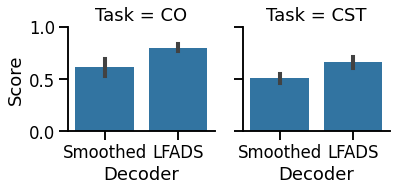

In [4]:
co_smoothed_scores = cross_val_score(LinearRegression(), df_co['M1_rates'], df_co[('hand_vel',0)], cv=5, groups=df_co.reset_index()['trial_id'])
co_lfads_scores = cross_val_score(LinearRegression(), df_co['lfads_rates'], df_co[('hand_vel',0)], cv=5, groups=df_co.reset_index()['trial_id'])
cst_smoothed_scores = cross_val_score(LinearRegression(), df_cst['M1_rates'], df_cst[('hand_vel',0)], cv=5, groups=df_cst.reset_index()['trial_id'])
cst_lfads_scores = cross_val_score(LinearRegression(), df_cst['lfads_rates'], df_cst[('hand_vel',0)], cv=5, groups=df_cst.reset_index()['trial_id'])

print('CO smoothed:', co_smoothed_scores.mean())
print('CO lfads:', co_lfads_scores.mean())
print('CST smoothed:', cst_smoothed_scores.mean())
print('CST lfads:', cst_lfads_scores.mean())

score_df = pd.DataFrame({
    ('CO','Smoothed'): co_smoothed_scores,
    ('CO','LFADS'): co_lfads_scores,
    ('CST','Smoothed'): cst_smoothed_scores,
    ('CST','LFADS'): cst_lfads_scores,
}).rename_axis(('Task','Decoder'),axis=1).stack(level=['Task','Decoder'])

score_df.name = 'Score'
score_df

g = sns.FacetGrid(score_df.reset_index(),col='Task',sharey=True)
g.map(sns.barplot,'Decoder','Score',order=['Smoothed','LFADS'])
for ax in g.axes.flatten():
    ax.set_ylim(0,1)

In [5]:
df_co['True Velocity'] = df_co[('hand_vel',0)]
df_co['Smoothed decoder'] = cross_val_predict(LinearRegression(), df_co['M1_rates'], df_co[('hand_vel',0)], cv=5, groups=df_co.reset_index()['trial_id'])
df_co['LFADS decoder'] = cross_val_predict(LinearRegression(), df_co['lfads_rates'], df_co[('hand_vel',0)], cv=5, groups=df_co.reset_index()['trial_id'])

df_cst['True Velocity'] = df_cst[('hand_vel',0)]
df_cst['Smoothed decoder'] = cross_val_predict(LinearRegression(), df_cst['M1_rates'], df_cst[('hand_vel',0)], cv=5, groups=df_cst.reset_index()['trial_id'])
df_cst['LFADS decoder'] = cross_val_predict(LinearRegression(), df_cst['lfads_rates'], df_cst[('hand_vel',0)], cv=5, groups=df_cst.reset_index()['trial_id'])

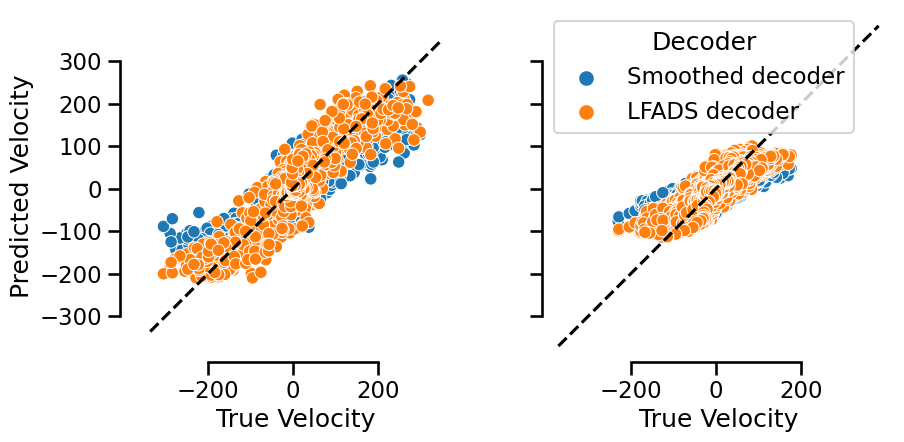

In [6]:
def plot_predicted_velocities(df,ax=None):
    pred_df = (
        df.melt(
            id_vars=[('True Velocity','')],
            value_vars=[('Smoothed decoder',''),('LFADS decoder','')],
            var_name='Decoder',
            value_name='Predicted Velocity',
            ignore_index=False,
        )
    ).rename(columns={('True Velocity',''):'True Velocity'})
    ax=sns.scatterplot(ax=ax,x='True Velocity', y='Predicted Velocity', hue='Decoder', data=pred_df)
    ax.plot(ax.get_xlim(), ax.get_xlim(), '--', color='black')
    ax.set_aspect('equal')
    sns.despine(ax=ax,trim=True)

fig,axs = plt.subplots(1,2,figsize=(10,5),sharex=True,sharey=True)
plot_predicted_velocities(df_co,ax=axs[0])
plot_predicted_velocities(df_cst,ax=axs[1])
axs[0].legend().remove()

In [7]:
def plot_trial_pred(trial,ax=None):
    trial_melt = (
        trial.melt(
            value_vars=[('True Velocity',''),('Smoothed decoder',''),('LFADS decoder','')],
            var_name='Decoder',
            value_name='Velocity',
            ignore_index=False,
        )
    ).reset_index()
    ax = sns.lineplot(
        ax=ax,
        data=trial_melt,
        x='Time bin',
        y='Velocity',
        hue='Decoder',
        palette={'True Velocity':'black','Smoothed decoder':'mediumorchid','LFADS decoder':'goldenrod'},
        style='Decoder',
        dashes={'True Velocity':(7,3),'Smoothed decoder':(1,0),'LFADS decoder':(1,0)},
    )
    sns.despine(ax=ax,trim=True)

@interact(cst_trial_id=list(df_cst.groupby('trial_id').groups.keys()),co_trial_id=list(df_co.groupby('trial_id').groups.keys()))
def plot_trials(cst_trial_id,co_trial_id):
    fig,axs = plt.subplots(1,2,figsize=(10,5),sharey=True)
    plot_trial_pred(df_cst.groupby('trial_id').get_group(cst_trial_id),ax=axs[0])
    plot_trial_pred(df_co.groupby('trial_id').get_group(co_trial_id),ax=axs[1])
    axs[1].legend().remove()

interactive(children=(Dropdown(description='cst_trial_id', options=(1, 2, 3, 4, 5, 6, 9, 10, 12, 13, 14, 15, 2…